New stis data!!!

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import os
import glob
from astropy.table import Table
from astropy.io import ascii
from astropy.convolution import convolve, Box1DKernel
from scipy.interpolate import interp1d

import astropy.units as u

import astropy.constants as const
from astropy.modeling import models, fitting
from astropy.coordinates import SkyCoord
from matplotlib.gridspec import GridSpec
from datetime import datetime



#matplotlib set up
%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20

In [2]:
path = '/media/david/5tb_storage1/eg_uma/hst/stis/data/'
x1ds = glob.glob('{}*x1d.fits'.format(path))
x1ds

['/media/david/5tb_storage1/eg_uma/hst/stis/data/oehua1010_x1d.fits',
 '/media/david/5tb_storage1/eg_uma/hst/stis/data/oehua2010_x1d.fits',
 '/media/david/5tb_storage1/eg_uma/hst/stis/data/oehua4010_x1d.fits']

1194.553066804444 1249.0873405005793


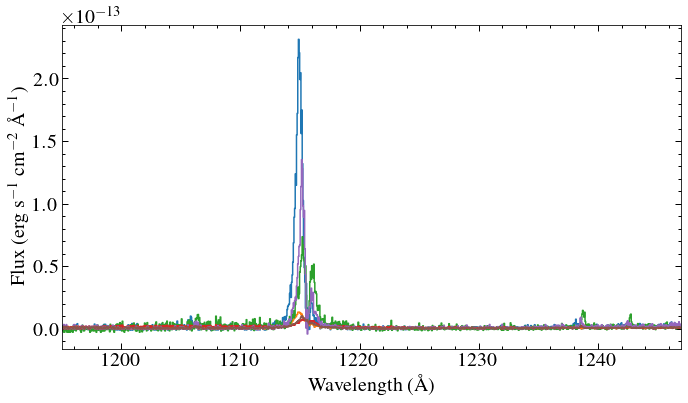

In [4]:
plt.figure(figsize=(10,6))
for x in x1ds:
    data = fits.getdata(x, 1)[0]
    plt.step(data['WAVELENGTH'],data['FLUX'])
    plt.step(data['WAVELENGTH'],data['ERROR'])
plt.xlabel('Wavelength (\AA)')
plt.ylabel('Flux (erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)')
plt.tight_layout()
plt.xlim(1195, 1247)
# plt.savefig('plots/1st_look.png', dpi=150)
print(data['WAVELENGTH'][0], data['WAVELENGTH'][-1])

(-1e-15, 1e-14)

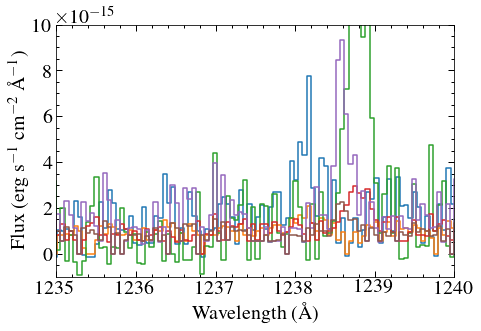

In [149]:
plt.figure(figsize=(7,5))
for x in x1ds:
    data = fits.getdata(x, 1)[0]
    plt.step(data['WAVELENGTH'],data['FLUX'])
    plt.step(data['WAVELENGTH'],data['ERROR'])
plt.xlabel('Wavelength (\AA)')
plt.ylabel('Flux (erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)')
plt.tight_layout()
plt.xlim(1235, 1240)
plt.ylim(-0.1e-14, 1e-14)

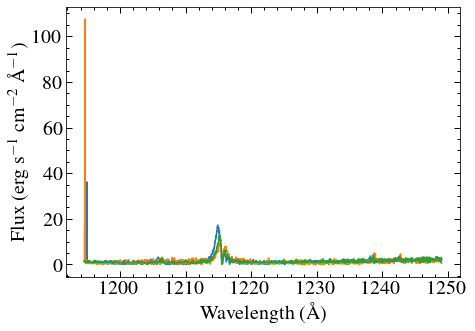

In [150]:
plt.figure(figsize=(7,5))
for x in x1ds:
    data = fits.getdata(x, 1)[0]
    mask = (data['FLUX'] > 0)
    plt.step(data['WAVELENGTH'][mask],abs(data['FLUX'][mask]/data['ERROR'][mask]))
    
plt.xlabel('Wavelength (\AA)')
plt.ylabel('Flux (erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)')
plt.tight_layout()


In [151]:
# Si III,1206.499,High,4.8
# N V,1238.821,High,5.3
# N V,1242.804,High,5.3

In [152]:
lines = [1206.499, 1238.821, 1242.804]
names = ['Si\,{\sc iii}', 'N\,{\sc v}', 'N\,{\sc v}']
fitter = fitting.LevMarLSQFitter()


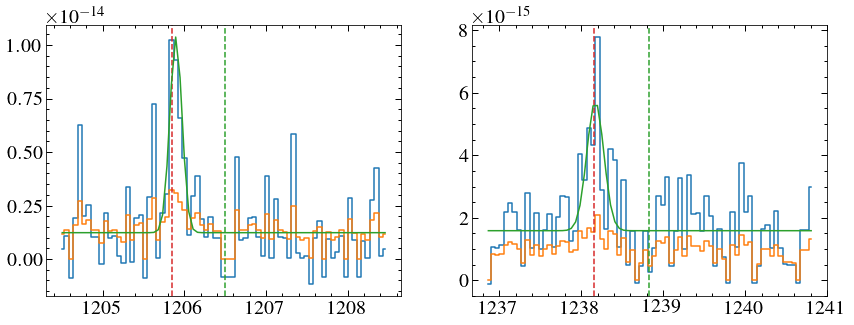

-152.39677640788386 3.6311798260389887


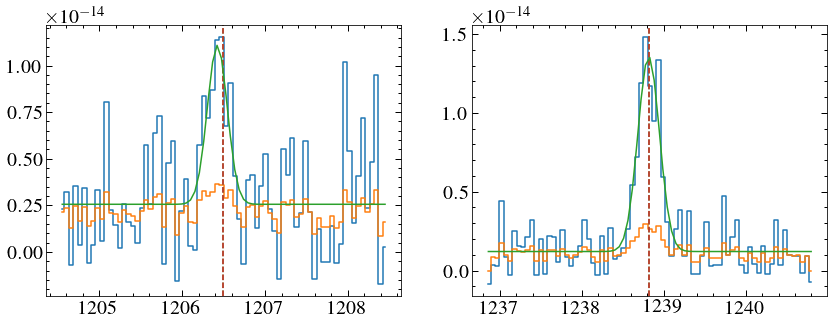

-3.2818755753303215 5.4132910471262825


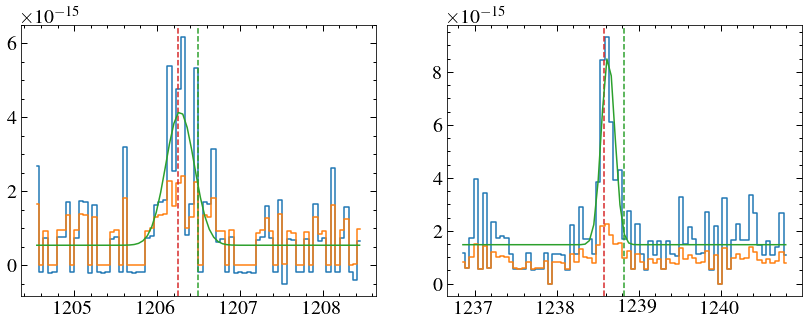

-47.95553817634172 2.978066060322101


In [171]:
def dv_average(dvs, es):
    """
    Returns a variance-weighted dv with standard error of the weighted mean (variance weights, scale corrected).
    
    """
    weights = 1 / (es**2)
    dv = np.average(dvs, weights = weights)
    var = 1 / np.sum(weights)
    rcs = np.sum((((dv - dvs)**2) * weights)) / (len(dvs)-1) #reduced chi-squared
    error = (var * rcs)**0.5
    return dv, error


guess_dv = np.array([-160, 0, -60])*u.km/u.s
for i, x in enumerate(x1ds):
    data = fits.getdata(x, 1)[0]
    w, f, e = data['WAVELENGTH'], data['FLUX'], data['ERROR']
    dvs = []
    dves = []
    for j, line in enumerate(lines[:2]): #nv 1242 is only barely detected
        plt.subplot(1, 2, j+1)
        guess_line = guess_dv[i].to(u.AA,  equivalencies=u.doppler_optical(line*u.AA)).value
#         print(guess_line)
        mask = (w > line-2) & (w < line+2)
        wline, fline, eline = w[mask], f[mask], e[mask]
        plt.step(wline, fline, where='mid')
        plt.step(wline, eline, where='mid')
        plt.axvline(line, ls='--', c='C2')
        plt.axvline(guess_line, ls='--', c='C3')
        gg_init = models.Const1D(0.15e-14)+models.Gaussian1D(1e-14, guess_line, 0.1)
        gg_fit = fitter(gg_init, wline, fline, maxiter=100000)
        #print(gg_fit)
        fit_e = np.sqrt(np.diag(fitter.fit_info['param_cov']))
        plt.plot(wline, gg_fit(wline))
        obs_line = gg_fit[1].mean.value*u.AA
        dv = obs_line.to(u.km/u.s,  equivalencies=u.doppler_optical(line*u.AA))
       # print(fit_e)
        eup = (obs_line+fit_e[2]*u.AA).to(u.km/u.s,  equivalencies=u.doppler_optical(line*u.AA))
        edo = (obs_line-fit_e[2]*u.AA).to(u.km/u.s,  equivalencies=u.doppler_optical(line*u.AA))
        dve= np.mean([abs(dv-eup).value, abs(dv-edo).value])*u.km/u.s
#         print(dv, dve)
        dvs.append(dv.value)
        dves.append(dve.value)
         
    plt.show()
    dv_spec, dve_spec = dv_average(np.array(dvs), np.array(dves))
    print(dv_spec, dve_spec)
       

In [ ]:
lyatab = Table.read('EGUMa_LyA_ISM_estimate.txt', format='ascii.basic')


/media/david/5tb_storage1/eg_uma/hst/stis/data/oehua1010_x1d.fits -152
/media/david/5tb_storage1/eg_uma/hst/stis/data/oehua2010_x1d.fits -3
/media/david/5tb_storage1/eg_uma/hst/stis/data/oehua4010_x1d.fits -48.0


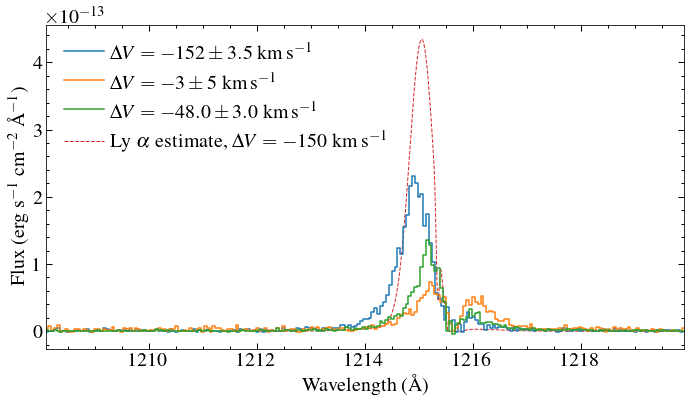

In [173]:
dv_labs = [-152,-3, -48.0]
dve_labs = [3.5, 5, 3.0]

plt.figure(figsize=(10,6))
for i, x in enumerate(x1ds):
    print(x, dv_labs[i])
    data = fits.getdata(x, 1)[0]
    plt.step(data['WAVELENGTH'],data['FLUX'], label = r'$\Delta V = {0}\pm{1}$'.format(dv_labs[i], dve_labs[i]) +' km\,s$^{-1}$')
plt.plot(lyatab['wave'], lyatab['flux_-150kms']*lyatab['ISM_attenuation'], label=r'Ly $\alpha$ estimate, $\Delta V = -150$ km\,s$^{-1}$', c='C3', lw=1, ls='--', zorder=-1)

plt.xlabel('Wavelength (\AA)')
plt.ylabel('Flux (erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)')
plt.legend(loc=2)
plt.xlim(1208.1, 1219.9)
plt.tight_layout()
plt.savefig('plots/1st_look_model.png', dpi=150)

In [ ]:
# lyatab

Compare with COS

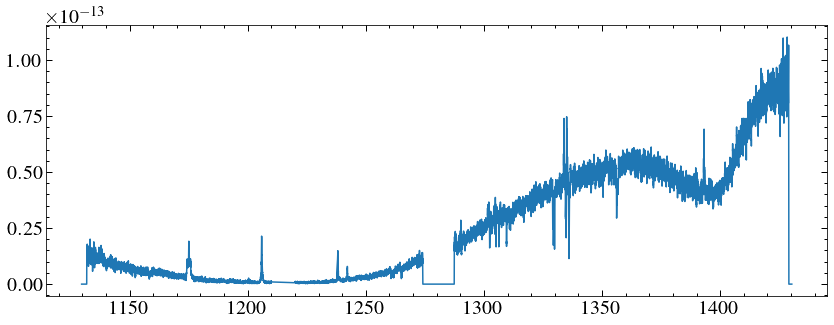

In [157]:
cpath = '/media/david/5tb_storage1/pceb_data/eg_uma/'
x = glob.glob('{}*x1dsum.fits'.format(cpath))[0]

smooth=5
data = fits.getdata(x, 1)
wc = np.array([], dtype=float)
fc = np.array([], dtype=float)
ec = np.array([], dtype=float)
for dt in data[::-1]:
    wi, fi, ei, dq = dt['WAVELENGTH'], dt['FLUX'], dt['ERROR'], dt['DQ']
   # mask = (fi>0) & (dq == 0) & (wi < 1213) | (wi > 1217) & (fi>0) & (dq == 0) 
    mask = (dq==0)
    wi, fi, ei = wi[mask], fi[mask], ei[mask]
    wc = np.concatenate((wc, wi))
    fc = np.concatenate((fc, fi))
    ec = np.concatenate((ec, ei))    

fc = convolve(fc,Box1DKernel(smooth))
ec = convolve(ec,Box1DKernel(smooth))/(smooth**0.5)

# plt.plot(wc, fc)

mask = (wc < 1210) | (wc > 1220)
wc1, fc1, ec1 = wc[mask], fc[mask], ec[mask]
plt.plot(wc1, fc1)

In [158]:
data = fits.getdata(x1ds[0])[0]
ws, fs, es = data['WAVELENGTH'], data['FLUX'], data['ERROR']

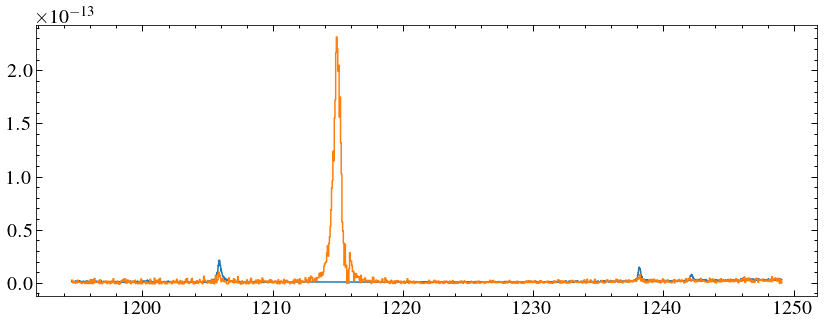

In [159]:
mask = (wc1 > ws[0]) & (wc1 < ws[-1])
plt.plot(wc1[mask], fc1[mask])
plt.step(ws, fs, where='mid')

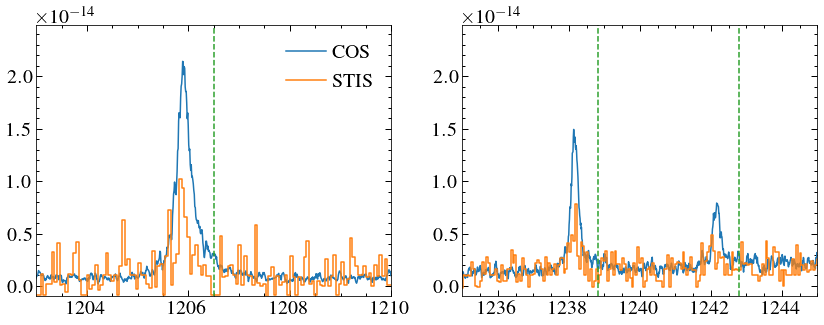

In [169]:
plt.subplot(121)
plt.plot(wc1[mask], fc1[mask], label='COS')
plt.step(ws, fs, where='mid', label='STIS')
plt.xlim(1203, 1210)
plt.ylim(-1e-15, 2.49e-14)
[plt.axvline(line, c='C2', ls='--') for line in lines]
plt.legend()

plt.subplot(122)
plt.plot(wc1[mask], fc1[mask])
plt.step(ws, fs, where='mid')
plt.xlim(1235, 1245)
plt.ylim(-1e-15, 2.49e-14)
[plt.axvline(line, c='C2', ls='--') for line in lines]

Is the COS and STIS wd flux consitant? 

5.585796213024902e-14
6.300544228989636e-14
0.8865577337468589


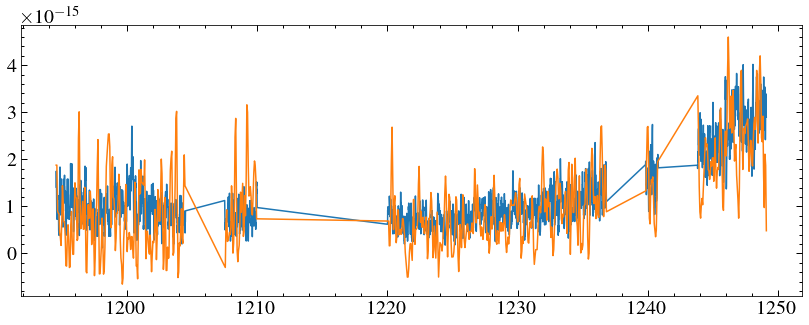

In [185]:
cos_mask = (wc >= ws[0]) & (wc < lines[0]-2) | (wc > lines[0]+1) & (wc < 1210) | (wc > 1220) & (wc < lines[1]-2) | (wc > lines[1]+1) & (wc < lines[2]-2) | (wc > lines[2]+1) & (wc <=ws[-1])
plt.plot(wc[cos_mask], fc[cos_mask])
stis_mask = (ws < lines[0]-2) | (ws > lines[0]+1) & (ws < 1210) | (ws > 1220) & (ws < lines[1]-2) | (ws > lines[1]+1) & (ws < lines[2]-2) | (ws > lines[2]+1) 


fsi = convolve(fs,Box1DKernel(2))
plt.plot(ws[stis_mask], fsi[stis_mask])

stis_int = np.trapz(fsi[stis_mask], ws[stis_mask])
cos_int = np.trapz(fc[cos_mask], wc[cos_mask])
print(stis_int)
print(cos_int)
print(stis_int/cos_int)